In [ ]:
%matplotlib inline
import os
os.chdir("C:/Users/ituki/Documents/Classes/605_649 Introduction to ML/Projects")
import numpy as np 
import pandas as pd  
import time
import random
import matplotlib.pyplot as plt
import copy
import dill
from itertools import combinations
from collections import namedtuple
pd.set_option('display.max_columns', None)
from IPython.core.display import display, HTML
display(HTML("<style>.container { height:100% !important; }</style>"))

s = namedtuple('s', ['x', 'y', 'vx', 'vy']) 

In [ ]:
#dill.dump(env_L.pi, open('pi_L1.pkl', 'wb'))
#dill.dump(Q_L_SARSA, open('Q_L_SARSA.pkl', 'wb'))
#dill.dump(Q_L_QLearning, open('Q_L_QLearning.pkl', 'wb'))
#dill.dump(Q_L_QLearning_restart, open('Q_L_QLearning_restart.pkl', 'wb'))
#dill.dump(Q_L_SARSA_restart, open('Q_L_SARSA_restart.pkl', 'wb'))
#pi_L = dill.load(open('pi_L1.pkl', 'rb'))
#dill.dump(env_L.pi, open('pi_L1.pkl', 'wb'))
pi_L = dill.load(open('pi_L1.pkl', 'rb'))
#Q_L = dill.load(open('Q_L_SARSA200K.pkl', 'rb'))
#env.pi = pi_L

# Project 6 : Reinforcement Learning

In [ ]:

class environment:
    """
    class: Create environment from the text file by reading line by line and storing the index and the characters.
    It stores characters in a matrix. 
    """
    def __init__(self,file):
        File = open(file, 'r')
        Lines1 = File.readlines()
        Lines1.pop(0)  # skipping the fist line 

        self.nrow = len(Lines1)
        print(self.nrow)
        self.ncol = len(Lines1[0])-1
        print(self.ncol)
        self.env = np.empty((self.nrow, self.ncol), dtype = str)
        self.actions = np.array([[i, j] for i in [-1, 0, 1] for j in [-1, 0, 1]])
        self.A = list(range(len(self.actions)))
        self.starts = []
        self.start_state = []  
        self.finish = []
        self.finish_state = []
        self.on_track = []
        self.on_track_state = []
        self.off_track = []
        self.off_track_state = []
        self.S = []
        self.v = {}
        self.V = {}
        self.pi = {}
        self.action_list = {}

        s = namedtuple('s', ['x', 'y', 'vx', 'vy'])  # state is represented as a 4 variable tuple s(x, y, vx, vy)

        for i in range(self.nrow):
            for j in range(self.ncol):
                char = Lines1[i][j]
                self.env[i][j] = char
                if char == 'S':
                    self.starts.append((i, j))
                    self.start_state.append(s(i, j, 0, 0))
                if char == 'F':
                    self.finish.append((i,j))
                if char == '.':
                    self.on_track.append((i,j))
                if char == '#':
                    self.off_track.append((i,j))
        self.tracks = self.starts +self.on_track + self.finish

        for x, y in self.tracks:
            for vx in range(-5, 5+1):
                for vy in range(-5, 5+1):
                    state = s(x,y,vx, vy)
                    i, j = x+vx, y+vy
                    self.pi[state] = [1/len(self.A) for a in self.A]
                    self.V[state] = random.random()
                    if (i<0) | (j<0) | (i>=self.nrow) | (j>=self.ncol) :
                        self.off_track_state.append(state)
                        self.V[state] = -10
                    else:
                        #self.pi[state] = [1/len(self.A) for a in self.A]
                        index, char = self.landpoint(x, y, i, j)
                        if (index == (i, j)) & (char != 'F'):
                            self.on_track_state.append(state)
                        if char == 'F':
                            self.finish_state.append(state)
                            self.V[state] = 0
                        if char =='S':
                            self.on_track_state.append(state)
                        else:
                            self.off_track_state.append(state)
                            self.V[state] = -10
                                                        
        self.s = random.choice(self.start_state) #starting state
        self.S = self.start_state + self.on_track_state+self.finish_state 

    def landpoint(self, x1, y1, x2, y2):
        """
        conduct line search to find all the characters between point(x1, y1) and (x2, y2)
        It will return the closest non-# location, and the character at that location.
        """
        [x1, x2] = [np.clip(i, 0, self.nrow-1) for i in [x1, x2]]
        [y1, y2] = [np.clip(i, 0, self.ncol-1) for i in [y1, y2]]
        indices = [(x1, y1)]
        chars = [self.env[x1][y1]]
        reverse = False
        if (x1 == x2) & (y1 == y2):
            indices, chars = [(x1, y1)], [self.env[x1][y1]]
        elif (x1 == x2) & (y1 != y2):
            if y1 > y2:
                y1, y2 = y2, y1
                reverse = True
            indices,chars = [(x1,y) for y in range(y1, y2+1)], [self.env[x1][y] for y in range(y1, y2+1)]
        elif (x1 != x2) & (y1 == y2):
            if x1 > x2:
                x1, x2 = x2, x1
                reverse = True
            indices, chars = [(x,y1)  for x in range(x1, x2+1)],  [self.env[x][y1] for x in range(x1, x2+1)]
        else:
            indices, chars = [], []
            slope = (y2-y1)/(x2-x1)
            if x1>x2:
                reverse = True
                (x1, y1, x2, y2) = (x2, y2, x1, y1)
            steps = abs(int(x2-x1))
            y = y1
            for i in range(steps+1):
                indices.append((x1+i, round(y)))
                chars.append(self.env[x1+i][min(round(y), self.ncol-1)])
                y = y+slope
        if reverse:
            indices = list(reversed(indices))
            chars = list(reversed(chars))
        # find the last non-wall points
        if '#' not in chars:
            index, char = indices[-1], chars[-1]
        else:
            wall = chars.index('#')
            index = indices[wall-1]
            char = chars[wall-1]
        return index, char


    def reset(self):
        """
        Reset the starting state by chooing one of the starting point randomly.
        """
        self.s = random.choice(self.start_state)
        return self.s

    def take_action(self, s0, a = 4, restart = False):
        """
        determines the next state given the state and action. 
        The action fails with probability 0.2. O.W. 
        """
        s = namedtuple('s', ['x', 'y', 'vx', 'vy'])
        failed = False
        # action fails 
        if random.random() <0.2:
            failed = True  
            a = 4
        ax, ay = self.actions[a]
        (x,y, vx, vy) = s0
        vx1 = np.clip(vx + ax, -5, 5)
        vy1 = np.clip(vy + ay, -5, 5)
        x1 = x + vx1
        y1 = y + vy1
        s1 = s(x, y, vx1, vy1)
        s1_ = s(x1, y1, vx1, vy1)
        r1 = -1
        status = 0
        (x0, y0), char = self.landpoint(x,y, x1, y1)
        if char =='F': 
            # done
            s1_ = s(x0, y0, 0, 0)
            r1 = 0
            status = 1
            return s1_, r1, status, failed

        if (x0, y0) == (x1, y1):
            s1_ = s(x1, y1, vx1, vy1)
            r1 = -1
            status = 0
            return s1_, r1, status, failed

        else:
            s1_ = s(x0, y0, 0, 0)
            if restart == True:
                s1_ = random.choice(self.start_state)
            r1 = -1
            status = -2
            return s1_, r1, status, failed
        
        return s1_, r1, status, failed
 
    def transitions(self, curr_s, a, restart=False):
        # 20 % of time acceleration fails:
        p0 = 0.2
        s0, r0, status0, failed = self.take_action(curr_s)
        # o.w take action a
        p1 = 0.8
        s1, r1, status1, failed = self.take_action(curr_s, a)
        p = np.array([[s0, r0, p0],[s1, r1, p1]])
        return p


#env = environment('C:/Users/ituki/Documents/Classes/605_649 Introduction to ML/Projects/L-track.txt')
#pd.DataFrame(env.env.reshape((env.nrow, env.ncol)))

In [ ]:
env_L = environment('C:/Users/ituki/Documents/Classes/605_649 Introduction to ML/Projects/L-track.txt')
pd.DataFrame(env_L.env)

In [ ]:
def argmax(v):
    """
    argumax function that return the index of max val and chooses ties randomly
    """
    top_value = float("-inf")
    ties = []
    for i in range(len(v)):
        if v[i] > top_value:
            top_value = v[i]
            ties = [i]
        else:
            if v[i] == top_value:
                ties.append(i)
    if ties == []:
        print(v)
    return random.choice(ties)

In [ ]:
def softmax(v):
    return np.exp(v)/sum(np.exp(v))

In [ ]:
def next_point(env, s0, a):
    ax, ay = env.actions[a]
    (x,y, vx, vy) = s0
    vx1 = np.clip(vx + ax, -5, 5)
    vy1 = np.clip(vy + ay, -5, 5)
    x1 = x + vx1
    y1 = y + vy1
    return (x1, y1)

In [ ]:
def choose_action(env, s0, pi, e = 0.0):
    """
    Function implementing e-greedy 
    chooses action non-deterministically with probability e, 
    o.w. chooses deterministically according to policy, pi
    """
    assert pi[s0] != []
    # explore
    if np.random.uniform() < e:
        action = random.choice(env.A)
    # exploit
    else:
        action = argmax(pi[s0])
    return action

In [ ]:
def test_run(env, pi, max_iter = 100, e = 0, restart = False, Print = False):
    """
    Run trial to see the path visually in 2D. Returns the total reward for the trial.
    when 'restart', the car is set back to the starting point.
    """
    s0 = env.reset()
    r = 0
    X = []
    Y = []
    X_failed = []
    Y_failed = []
    X_crash = []
    Y_crash = []
    X_projection = []
    Y_projection = []
    for i in range(max_iter):
        X.append(s0.x)
        Y.append(s0.y)
        a = choose_action(env, s0, pi , e)
        s1, r1, status1, failed = env.take_action(s0, a, restart)
            
        if Print:
            print('\n','S', s0, "A", a, "S'", s1)
        if failed:
                X_failed.append(s1.x)
                Y_failed.append(s1.y)
        if status1 == -2:
            (x1, y1) = next_point(env, s0, a)
            X_projection.append(x1)
            Y_projection.append(y1)
            if restart:
                X_crash.append(s0.x)
                Y_crash.append(s0.y)
            else:
                X_crash.append(s1.x)
                Y_crash.append(s1.y)
        if status1 == 1:
            X.append(s1.x)
            Y.append(s1.y)
            print('done', s1, i, r)
            break
        else:
            r+=r1
            s0 = s1
    X = -(np.array(X)-env.nrow)
    X_failed = -(np.array(X_failed)-env.nrow)
    X_crash = -(np.array(X_crash)-env.nrow)
    X_projection = -(np.array(X_projection)-env.nrow)
    plt.plot(Y, X)
    plt.plot(Y_failed, X_failed, 'o', color = 'red')
    plt.plot(Y_crash, X_crash, '*', color = 'black', markersize=12)
    plt.plot(Y_projection, X_projection, '*', color = 'blue', markersize=12)
    plt.xlim((0,env.ncol))
    plt.ylim((0, env.nrow))
    return r

# When it crashes... 

done s(x=1, y=33, vx=0, vy=0) 14 -14


-14

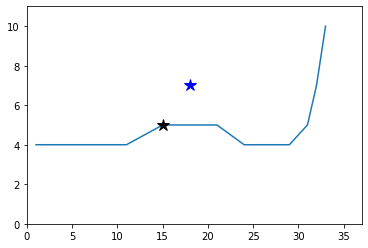

In [725]:
test_run(env_L, pi_L)

## Value Iteration: V update

In [ ]:
def value_iteration(env, V, pi, restart =False, gamma = 0.9, theta = 0.01, max_iter = 1):
    """
    outer loop function for value iteration. 
    """
    counter = 0
    for _ in range(max_iter):
        delta = 0
        for s in env.S:
            v = V[s]
            bellman_update(env, V, pi, s, gamma, restart)
        delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
        counter += 1
        print(counter)

In [ ]:
def bellman_update(env, V, pi, s0, gamma = 0.9, restart= False):
    """ 
    update v value by calculating weighted future values. 
    """
    v = [0 for _ in range(len(env.A))]
    for i, a in enumerate(env.A):
        temp = 0
        transitions = env.transitions(s0, a, restart)
        for [sp, r ,p] in transitions:
             temp += p*(r+gamma*V[sp])  # weighted sum of future values. 
        v[i] = temp
    best_action = argmax(v)
    V[s0] = v[best_action]
    pi[s0] = softmax(v)

In [727]:
value_iteration_DEMO(env_L, env_L.V, env_L.pi, max_iter=1,)


 s(x=6, y=1, vx=0, vy=0)
before -1.0265123292869651
after -1.0355690545151504

 s(x=7, y=1, vx=0, vy=0)
before -0.7478144448042229
after -0.7574865551360104

 s(x=8, y=1, vx=0, vy=0)
before -0.8451671101064676
after -0.8550534251892478

 s(x=9, y=1, vx=0, vy=0)
before -1.0517518705473352
after -1.946576683492602

 s(x=6, y=1, vx=-5, vy=-1)
before -1.9238610963582685
after -1.9320121490636355

 s(x=6, y=1, vx=-5, vy=0)
before -1.9238610963582685
after -1.9320121490636355

 s(x=6, y=1, vx=-5, vy=1)
before -1.9238610963582685
after -1.9320121490636355

 s(x=6, y=1, vx=-5, vy=2)
before -1.9238610963582685
after -1.9320121490636355

 s(x=6, y=1, vx=-5, vy=3)
before -1.9238610963582685
after -1.9320121490636355

 s(x=6, y=1, vx=-5, vy=4)
before -1.9238610963582685
after -1.9320121490636355

 s(x=6, y=1, vx=-5, vy=5)
before -1.9238610963582685
after -1.9320121490636355

 s(x=6, y=1, vx=-4, vy=-1)
before -1.9238610963582685
after -1.9320121490636355

 s(x=6, y=1, vx=-4, vy=0)
before -1.923861

In [726]:
def value_iteration_DEMO(env, V, pi, n = 20, restart =False, gamma = 0.9, theta = 0.001, max_iter = 1):
    counter = 0
    for _ in range(max_iter):
        delta = 0
        for s in env.S[0:n]:
            print('\n',s)
            print('before',V[s])
            v = V[s]
            bellman_update(env, V, pi, s, gamma, restart)
            print('after', V[s])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
        counter += 1
        print(counter)

In [ ]:
def generate_Q(env):
    Q = {}
    for s0 in env.S:
        if s0 in env.finish_state:
            Q[s0] = [0 for a0 in env.A]
        else:
            Q[s0] = [random.random() for a0 in env.A]
        for a0 in env.A:
            s1, r1, status1, failed = env.take_action(s0, a0)
            Q[s0][a0] = r1
            if s1 not in Q.keys():
                Q[s1] = [random.random() for a0 in env.A]
    return Q

In [ ]:
Q_L_SARSA_restart = generate_Q(env_L)

## SARSA : Q- update

In [ ]:
def q_choose_action(env, Q, s0, e = 0.2):
    # explore
    if np.random.uniform() < e:
        action = random.choice(env.A)
    # exploit
    else:
        action = argmax(Q[s0])
    return int(action)

In [ ]:
def SARSA(env, Q, gamma = 0.9, num_episode = 10000, max_iter = 30, alpha = 0.9, e = 0.0, restart= False, DEMO= False):
    Rewards = []
    for episode in range(num_episode):
        reward = sarsa(env, Q, gamma, max_iter, alpha, DEMO= DEMO)
        Rewards.append(reward)
        if episode % 1000 ==0:
            print(episode)
        e *= 1-1e-5
    return Rewards

In [728]:
r = SARSA(env_L, Q_L_SARSA, num_episode =1, DEMO=True)


 s(x=8, y=1, vx=0, vy=0) 5
before -7.47793985029803
after -7.704925263771208

 s(x=8, y=1, vx=0, vy=0) 5
before -7.704925263771208
after -7.3354435068084225

 s(x=8, y=2, vx=0, vy=1) 5
before -6.99376664250778
after -6.905395506076976

 s(x=8, y=4, vx=0, vy=2) 5
before -6.550640545464442
after -6.725876914035994

 s(x=8, y=7, vx=0, vy=3) 5
before -6.383719579616728
after -6.4674220510337745

 s(x=8, y=10, vx=0, vy=3) 5
before -6.085247028484075
after -5.7377869859009465

 s(x=8, y=14, vx=0, vy=4) 5
before -5.22131146055869
after -5.682732527668569

 s(x=8, y=18, vx=0, vy=4) 0
before -5.260001705694691
after -5.533136437251618

 s(x=7, y=21, vx=-1, vy=3) 5
before -5.070538600842158
after -4.790917270992747

 s(x=6, y=24, vx=-1, vy=3) 8
before -4.1776091492697915
after -4.113832703623419

 s(x=6, y=28, vx=0, vy=4) 1
before -3.4519404798721474
after -3.827761484088

 s(x=5, y=32, vx=-1, vy=4) 4
before -3.188354859383686
after -2.8535027376858397

 s(x=5, y=32, vx=0, vy=0) 2
before -2.018

In [ ]:
def sarsa(env, Q, gamma = 0.9, max_iter = 30, alpha = 0.9, e = 0.0, restart = False, DEMO= False):
    finished = False
    s0 = env.reset()
    a0 = q_choose_action(env, Q, s0, e)
    t = 0
    total_r = 0
    while not finished:
        s1, r1, status1, failed = env.take_action(s0, a0, restart)
        a1 = q_choose_action(env, Q, s1, e)
        if DEMO:
            print('\n',s0, a0)
            print('before', Q[s0][a0])
        Q[s0][a0] = Q[s0][a0] + alpha*(r1 + gamma*Q[s1][a1]- Q[s0][a0]) # bellman update
        if DEMO:
            print('after', Q[s0][a0])
            if t>=max_iter:
                break
        s0 = s1
        a0 = a1
        total_r +=r1
        finished = status1 > 0
        if finished:
            break
        t+=1
    return total_r

## Q-Learing : Q-update

In [ ]:
def Q_LEARNING(env, Q, gamma = 0.9, num_episode = 10000, max_iter = 30, alpha = 0.9, e = 0.2, restart = False, DEMO= False):
    Rewards = []
    for episode in range(num_episode):
        reward = Q_Learning(env, Q, gamma, max_iter, alpha, e, restart, DEMO)
        Rewards.append(reward)
        if episode % 1000 ==0:
            print(episode)
    return Rewards

In [ ]:
r = Q_LEARNING(env_L, Q_L_QLearning_restart, num_episode=2500, max_iter=500, restart=True)

In [ ]:
r = Q_LEARNING(env_L, Q_L_QLearning, num_episode=2500, max_iter=500)

In [729]:
Q_LEARNING(env_L, Q_L, num_episode=10, max_iter=30, DEMO=True)


 s(x=7, y=1, vx=0, vy=0) 2
before -8.282180130651701
after -8.281582318020337

 s(x=6, y=2, vx=-1, vy=1) 8
before -8.087990074994313
after -8.074068524484439
0

 s(x=8, y=1, vx=0, vy=0) 5
before -7.912435832968873
after -7.932232876483738

 s(x=8, y=2, vx=0, vy=1) 5
before -7.790467833936888
after -7.794465999898308

 s(x=8, y=1, vx=0, vy=0) 5
before -7.932232876483738
after -7.948790181168686

 s(x=8, y=2, vx=0, vy=1) 1
before -8.788524362956347
after -8.795721322867427

 s(x=7, y=1, vx=0, vy=0) 2
before -8.281582318020337
after -8.31595067165993

 s(x=7, y=1, vx=0, vy=0) 2
before -8.31595067165993
after -8.306092871735142

 s(x=9, y=1, vx=0, vy=0) 5
before -8.157378208584067
after -8.120315388855014

 s(x=9, y=2, vx=0, vy=1) 1
before -7.7467378999320005
after -7.658712643391699

 s(x=8, y=1, vx=0, vy=0) 0
before -8.863893363017748
after -8.721896923024563

 s(x=8, y=1, vx=0, vy=0) 6
before -9.10220626126862
after -8.912547241625258

 s(x=9, y=1, vx=0, vy=0) 5
before -8.1203153888550

[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2]

In [ ]:
def Q_Learning(env, Q, gamma = 0.9, theta = 0.1, max_iter = 30, alpha = 0.5, restart = False, DEMO = False):
    finished = False
    # Generate Q(s,a)
    #Q = generate_Q(env)
    s0 = env.reset()
    total_r = 0
    t = 0
    while not finished:
        a0 = q_choose_action(env, Q, s0)
        s1, r1, status, failed = env.take_action(s0, a0, restart)
        total_r += r1
        a1 = q_choose_action(env, Q, s1, e= 0)
        if DEMO:
            print('\n',s0, a0)
            print('before', Q[s0][a0])
        Q[s0][a0] = Q[s0][a0] + alpha*(r1 + gamma*Q[s1][a1]- Q[s0][a0]) # bellman update
        if DEMO:
            print('after', Q[s0][a0])
            if t>=max_iter:
                break
        s0 = s1
        finished = status > 0
        if finished:
            break
        t+=1
    return total_r

## Exploration vs Exploitation

In [730]:
s0 = env_L.s
print(s0)
actions = []
for _ in range(20):
    actions.append(choose_action(env_L,s0, Q_L, e = 0.2))
print(actions)

s(x=6, y=1, vx=0, vy=0)
[7, 7, 7, 7, 7, 7, 7, 7, 3, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7]


In [ ]:
def choose_action(env, s0, pi, e = 0.0):
    """
    Function implementing e-greedy 
    chooses action non-deterministically with probability e, 
    o.w. chooses deterministically according to policy, pi
    """
    assert pi[s0] != []
    # explore
    if np.random.uniform() < e:
        action = random.choice(env.A)
    # exploit
    else:
        action = argmax(pi[s0])
    return action

## Generation of paths as  sequence of <state, action, state'> 


 S s(x=7, y=1, vx=0, vy=0) A 5 S' s(x=7, y=2, vx=0, vy=1)

 S s(x=7, y=2, vx=0, vy=1) A 4 S' s(x=7, y=3, vx=0, vy=1)

 S s(x=7, y=3, vx=0, vy=1) A 5 S' s(x=7, y=5, vx=0, vy=2)

 S s(x=7, y=5, vx=0, vy=2) A 5 S' s(x=7, y=8, vx=0, vy=3)

 S s(x=7, y=8, vx=0, vy=3) A 1 S' s(x=6, y=11, vx=-1, vy=3)

 S s(x=6, y=11, vx=-1, vy=3) A 4 S' s(x=6, y=11, vx=0, vy=0)

 S s(x=6, y=11, vx=0, vy=0) A 5 S' s(x=6, y=12, vx=0, vy=1)

 S s(x=6, y=12, vx=0, vy=1) A 8 S' s(x=7, y=14, vx=1, vy=2)

 S s(x=7, y=14, vx=1, vy=2) A 2 S' s(x=7, y=17, vx=0, vy=3)

 S s(x=7, y=17, vx=0, vy=3) A 4 S' s(x=7, y=20, vx=0, vy=3)

 S s(x=7, y=20, vx=0, vy=3) A 4 S' s(x=7, y=23, vx=0, vy=3)

 S s(x=7, y=23, vx=0, vy=3) A 4 S' s(x=7, y=26, vx=0, vy=3)

 S s(x=7, y=26, vx=0, vy=3) A 4 S' s(x=7, y=29, vx=0, vy=3)

 S s(x=7, y=29, vx=0, vy=3) A 0 S' s(x=6, y=31, vx=-1, vy=2)

 S s(x=6, y=31, vx=-1, vy=2) A 0 S' s(x=4, y=32, vx=-2, vy=1)

 S s(x=4, y=32, vx=-2, vy=1) A 1 S' s(x=1, y=33, vx=0, vy=0)
done s(x=1, y=33, vx=0, vy=

-15

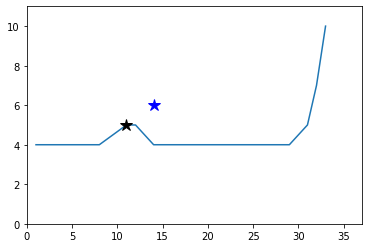

In [731]:
test_run(env_L, pi_L, max_iter=20, Print=True)

## - Value- Iteration


 S s(x=7, y=1, vx=0, vy=0) A 7 S' s(x=8, y=1, vx=1, vy=0)

 S s(x=8, y=1, vx=1, vy=0) A 3 S' s(x=9, y=1, vx=1, vy=0)

 S s(x=9, y=1, vx=1, vy=0) A 7 S' s(x=9, y=1, vx=0, vy=0)

 S s(x=9, y=1, vx=0, vy=0) A 2 S' s(x=8, y=2, vx=-1, vy=1)

 S s(x=8, y=2, vx=-1, vy=1) A 7 S' s(x=8, y=3, vx=0, vy=1)

 S s(x=8, y=3, vx=0, vy=1) A 5 S' s(x=8, y=5, vx=0, vy=2)

 S s(x=8, y=5, vx=0, vy=2) A 5 S' s(x=8, y=8, vx=0, vy=3)

 S s(x=8, y=8, vx=0, vy=3) A 5 S' s(x=8, y=12, vx=0, vy=4)

 S s(x=8, y=12, vx=0, vy=4) A 4 S' s(x=8, y=16, vx=0, vy=4)

 S s(x=8, y=16, vx=0, vy=4) A 4 S' s(x=8, y=20, vx=0, vy=4)

 S s(x=8, y=20, vx=0, vy=4) A 1 S' s(x=7, y=24, vx=-1, vy=4)

 S s(x=7, y=24, vx=-1, vy=4) A 4 S' s(x=6, y=28, vx=-1, vy=4)

 S s(x=6, y=28, vx=-1, vy=4) A 4 S' s(x=5, y=32, vx=-1, vy=4)

 S s(x=5, y=32, vx=-1, vy=4) A 4 S' s(x=5, y=32, vx=0, vy=0)

 S s(x=5, y=32, vx=0, vy=0) A 2 S' s(x=5, y=32, vx=0, vy=0)

 S s(x=5, y=32, vx=0, vy=0) A 2 S' s(x=4, y=33, vx=-1, vy=1)

 S s(x=4, y=33, vx=-1, vy=1) 

-17

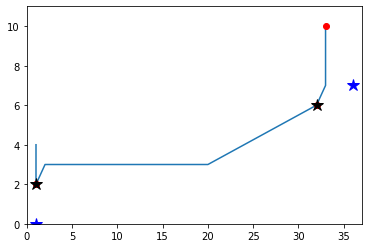

In [732]:
test_run(env_L, Q_L_SARSA, Print = True)

## - SARSA

## - Q-Learning


 S s(x=7, y=1, vx=0, vy=0) A 1 S' s(x=7, y=1, vx=0, vy=0)

 S s(x=7, y=1, vx=0, vy=0) A 1 S' s(x=6, y=1, vx=-1, vy=0)

 S s(x=6, y=1, vx=-1, vy=0) A 0 S' s(x=6, y=1, vx=0, vy=0)

 S s(x=6, y=1, vx=0, vy=0) A 5 S' s(x=6, y=2, vx=0, vy=1)

 S s(x=6, y=2, vx=0, vy=1) A 5 S' s(x=6, y=4, vx=0, vy=2)

 S s(x=6, y=4, vx=0, vy=2) A 5 S' s(x=6, y=7, vx=0, vy=3)

 S s(x=6, y=7, vx=0, vy=3) A 5 S' s(x=6, y=11, vx=0, vy=4)

 S s(x=6, y=11, vx=0, vy=4) A 5 S' s(x=6, y=15, vx=0, vy=4)

 S s(x=6, y=15, vx=0, vy=4) A 8 S' s(x=7, y=20, vx=1, vy=5)

 S s(x=7, y=20, vx=1, vy=5) A 3 S' s(x=8, y=24, vx=1, vy=4)

 S s(x=8, y=24, vx=1, vy=4) A 0 S' s(x=8, y=27, vx=0, vy=3)

 S s(x=8, y=27, vx=0, vy=3) A 3 S' s(x=8, y=29, vx=0, vy=2)

 S s(x=8, y=29, vx=0, vy=2) A 7 S' s(x=9, y=31, vx=1, vy=2)

 S s(x=9, y=31, vx=1, vy=2) A 1 S' s(x=9, y=31, vx=0, vy=0)

 S s(x=9, y=31, vx=0, vy=0) A 2 S' s(x=8, y=32, vx=-1, vy=1)

 S s(x=8, y=32, vx=-1, vy=1) A 0 S' s(x=7, y=33, vx=-1, vy=1)

 S s(x=7, y=33, vx=-1, vy=1) A 

-18

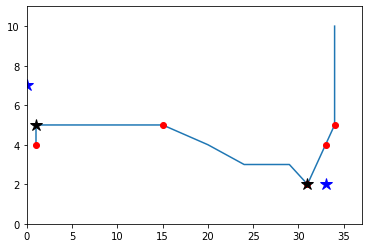

In [733]:
test_run(env_L, Q_L_QLearning, Print=True)

-100

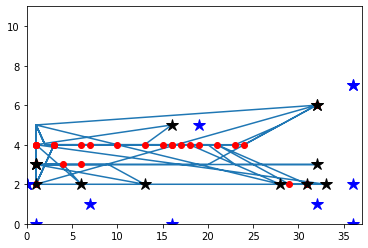

In [734]:
test_run(env_L, Q_L_SARSA, restart=True, max_iter= 100)

-100

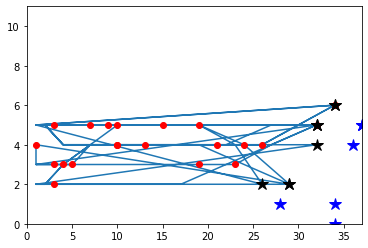

In [735]:
test_run(env_L, Q_L_SARSA_restart, max_iter= 100, restart=True)

In [ ]:
test_run(env_L, Q_L_QLearning, restart=True, max_iter= 100)

# Restart behavior for SARSA and Q-Learning

done s(x=1, y=35, vx=0, vy=0) 25 -25


-25

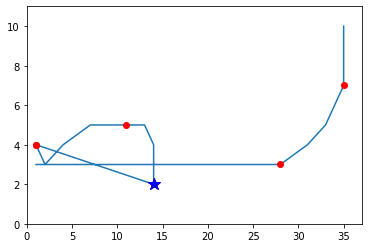

In [736]:
test_run(env_L, Q_L_QLearning_restart, restart=True, max_iter= 1000)